In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors,Word2Vec

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from string import punctuation

In [3]:
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')

tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [4]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [5]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [6]:
NUM_CLASSES = num_tags+1

In [7]:
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X) 

In [8]:
X_encoded

[[6423,
  24231,
  2,
  7652,
  102,
  170,
  2,
  47,
  1898,
  1,
  269,
  17,
  7,
  13230,
  619,
  1711,
  2761,
  3],
 [72, 24231, 11, 454, 4, 32828, 19723, 2, 1, 4782, 3119, 186, 3],
 [12009,
  32829,
  2,
  4197,
  102,
  170,
  5,
  662,
  454,
  4,
  5959,
  1141,
  1641,
  3190,
  2,
  13,
  1019,
  117,
  7,
  13230,
  619,
  4,
  26,
  595,
  615,
  11018,
  3],
 [7,
  307,
  4,
  8061,
  217,
  176,
  134,
  134,
  6,
  126,
  5345,
  4310,
  8466,
  42,
  1156,
  7,
  198,
  1314,
  4,
  2358,
  6189,
  231,
  7,
  186,
  4,
  782,
  3478,
  134,
  6,
  15,
  55,
  68,
  502,
  102,
  325,
  2,
  4783,
  477,
  118,
  163,
  3],
 [1,
  8061,
  4645,
  2,
  14758,
  2,
  11,
  6190,
  24232,
  217,
  15,
  6191,
  1,
  5731,
  2,
  18,
  100,
  1740,
  14759,
  6,
  15,
  3844,
  6996,
  9,
  163,
  376,
  63,
  3077,
  263,
  2,
  4783,
  39,
  118,
  389,
  3],
 [14760,
  322,
  2,
  1,
  531,
  4,
  61,
  8467,
  24233,
  281,
  9,
  389,
  627,
  5345,
  5346,
  2,
  

In [9]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)


In [10]:
vocab = word_tokenizer.word_index


In [11]:
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [12]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


In [13]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [14]:
X, Y = X_padded, Y_padded

In [15]:
X.shape

(72202, 100)

In [16]:
from gensim.test.utils import datapath, get_tmpfile

from gensim.models import KeyedVectors

from gensim.scripts.glove2word2vec import glove2word2vec

In [17]:
word2vec = KeyedVectors.load_word2vec_format('data/glove_gensim.txt',encoding = 'utf-8')

In [18]:
EMBEDDING_SIZE = 300
VOCAB_SIZE = len(vocab)+1

embedding_weights = np.zeros((VOCAB_SIZE,EMBEDDING_SIZE))

for word,index in vocab.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [19]:
embedding_weights.shape

(59449, 300)

In [20]:
Y = to_categorical(Y)  

In [21]:
TEST_SIZE = 0.15
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=TEST_SIZE,random_state = 4)

In [22]:
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [23]:
model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE,
                  output_dim = EMBEDDING_SIZE,
                  input_length =MAX_SEQ_LENGTH,
                  weights = [embedding_weights],
                  trainable = True))

model.add(Bidirectional(LSTM(64,return_sequences = True)))
model.add(TimeDistributed(Dense(NUM_CLASSES,activation = 'softmax')))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          17834700  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 13)           1677      
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])

In [26]:

print(Y_train.shape)
X_train.shape

(52165, 100, 13)


(52165, 100)

In [27]:
bidirect_training = model.fit(X_train, Y_train, batch_size=128, epochs=2, validation_data=(X_validation, Y_validation))

Epoch 1/2
408/408 [==============================] - 236s 565ms/step - loss: 0.1860 - acc: 0.9600 - val_loss: 0.0332 - val_acc: 0.9898
Epoch 2/2
408/408 [==============================] - 266s 651ms/step - loss: 0.0251 - acc: 0.9919 - val_loss: 0.0225 - val_acc: 0.9925


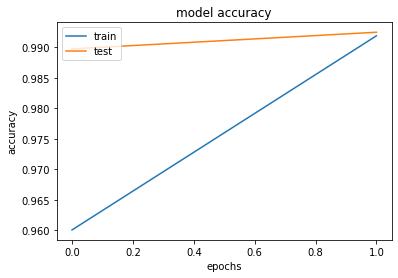

In [28]:
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'],loc ="upper left")
plt.show()

In [29]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 18s 53ms/step - loss: 0.0228 - acc: 0.9924
Loss: 0.0228266604244709,
Accuracy: 0.9923968315124512


In [35]:
seed = "this is a sentence" 
X_sentence = seed.split()
Y_sentence = []
for i in range(len(X_sentence)):
    
    model.predict("this",verbose=0)
    print(pred)


IndexError: list index out of range

In [36]:
def sample(preds,top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds/np.sum(exp_preds)
    return heapq.nlargest(top_n,range(len(preds)),preds.take)


In [ ]:
for i in range(len(X_sentence)):
    X = np.zeros((1,MAX_SEQ_LEN,len(vocab),EMBEDDING_SIZE))
    for t,word in enumerate(X_sentence):
        X[0,t,vocab(word),EBEDDING_SIZE] =1 
        
        preds = model.predict(X,verbose = 0)[0]
        next_tag = sample(preds,2)
        next_tag = 